In [1]:
# Standard libraries
import os 
import numpy as np  
import pandas as pd  

# Transformers library for working with pretrained models
from transformers import AutoTokenizer, AutoModel 

# PyTorch libraries for building and training models
import torch  
import torch.nn as nn  
import torch.nn.functional as F  

# PyTorch DataLoader for managing batches and loading data
from torch.utils.data import DataLoader, TensorDataset  

# Scikit-learn for model evaluation and data handling utilities
from sklearn.model_selection import train_test_split  
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, cohen_kappa_score  
from sklearn.preprocessing import LabelEncoder  

# Gensim for word embedding models
from gensim.models import KeyedVectors  # Load and handle word embeddings, e.g., GloVe or FastText

# Custom modules
from albert import * 

# Additional mathematical functions
import math  

/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-12 22:27:49.133422: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 22:27:49.147644: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731436069.164832 1331124 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731436069.169976 1331124 cuda_b

In [2]:
# Constants
BASE_DIR = '../'  # Base directory, set to one level up to access files and directories outside of current folder
DATASET_DIR = os.path.join(BASE_DIR, 'dataset')  # Directory path to store or load dataset files
SAVE_DIR = os.path.join(BASE_DIR, 'result')  # Directory path to save model results and outputs
MODEL_NAME = "albert-base-v2"  # Pre-trained ALBERT model name for loading via Hugging Face's Transformers
GLOVE_PATH = os.path.join(BASE_DIR, 'word_embeddings/glove.6B.300d.txt')  # Path to GloVe embeddings
FASTTEXT_PATH = os.path.join(BASE_DIR, 'word_embeddings/wiki.en.vec')  # Path to FastText embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check for CUDA (GPU) availability, else use CPU

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)  # Initialize tokenizer for ALBERT model
albert_model = AutoModel.from_pretrained(MODEL_NAME).to(device)  # Load ALBERT model and move to the correct device

# List of directories to check or create if they don’t exist
directories = [BASE_DIR, DATASET_DIR, SAVE_DIR, os.path.dirname(GLOVE_PATH), os.path.dirname(FASTTEXT_PATH)]

# Check each directory in the list and create it if it doesn't already exist
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)  # Create the directory if it doesn't exist
        print(f"Directory created: {directory}")  # Log directory creation
    else:
        print(f"Directory already exists: {directory}")  # Log if directory already exists

Directory already exists: ../
Directory already exists: ../dataset
Directory already exists: ../result
Directory already exists: ../word_embeddings
Directory already exists: ../word_embeddings


In [3]:
# Load embeddings
glove_model = load_glove_model(GLOVE_PATH)  # Load GloVe embeddings from the specified file path
fasttext_model = load_fasttext_model(FASTTEXT_PATH)  # Load FastText embeddings from the specified file path

In [4]:
# Load and preprocess the dataset
df = pd.read_csv('processed_essay_dataset.csv', sep=',', encoding='ISO-8859-1')  # Load dataset from CSV file
df = df.dropna(subset=['normalized_score'])  # Drop rows where 'normalized_score' column has missing values
df.fillna(0, inplace=True)  # Fill any remaining NaN values in the dataframe with 0

In [5]:
# Define quartiles for 'normalized_score' to categorize quality labels
q1, q3 = df['normalized_score'].quantile([0.25, 0.75])  # Calculate first and third quartiles for 'normalized_score'
df['quality_label'] = pd.cut(df['normalized_score'], bins=[-1, q1, q3, 100], labels=[0, 1, 2]).astype(int)  # Categorize into labels
df['quality_label'] = df['quality_label'].map({0: 0, 1: 1, 2: 2})  # Map quality labels to 0, 1, and 2

# Map essay types to numerical values
df['essay_type'] = df['essay_type'].map({'argumentative': 0, 'dependent': 1, 'narrative': 2})  # Map essay types to integers

In [6]:
# Filter the dataframe to include only rows where 'essay_type' is either 0 or 1 (argumentative or dependent essays)
df = df[df['essay_type'].isin([0, 1])]

In [9]:
# Define attributes for which we want to capture min and max values
attributes = ['content', 'organization', 'word_choice', 'sentence_fluency', 'conventions']

# Initialize dictionary to store min and max values for each attribute
attribute_ranges = {}

# Retrieve and store the min and max ranges for each attribute
for attribute in attributes:
    min_val, max_val = get_attribute_range(df, attribute)  # Get min and max values for the current attribute
    attribute_ranges[attribute] = (min_val, max_val)  # Store the range in attribute_ranges dictionary

# Print the ranges for each attribute
print("Attribute Ranges:")
for attribute, (min_val, max_val) in attribute_ranges.items():
    print(f"{attribute}: {min_val} to {max_val}")  # Print the min and max values for each attribute

Attribute Ranges:
content: 0.0 to 6.0
organization: 0.0 to 6.0
word_choice: 0.0 to 6.0
sentence_fluency: 0.0 to 6.0
conventions: 0.0 to 6.0


In [8]:
# Validate that 'quality_label' contains only the expected values: 0, 1, or 2
assert all(df['quality_label'].isin([0, 1, 2])), "Invalid quality labels!"

# Validate that 'essay_type' contains only the expected values: 0, 1, or 2
assert all(df['essay_type'].isin([0, 1, 2])), "Invalid essay type labels!"

In [9]:
# Check for NaN or Infinite values in the numeric columns
numeric_df = df.select_dtypes(include=[np.number])  # Only select numeric columns

# Check for NaN values
if numeric_df.isna().any().any():
    print("Data contains NaN values!")

# Check for infinite values
if np.isinf(numeric_df.values).any():
    print("Data contains Infinite values!")


Training model for embedding type: albert


/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Total Epoch Loss: 599.7822
Epoch 2/10, Total Epoch Loss: 167.0959
Epoch 3/10, Total Epoch Loss: 141.1358
Epoch 4/10, Total Epoch Loss: 124.7674
Epoch 5/10, Total Epoch Loss: 115.9977
Epoch 6/10, Total Epoch Loss: 112.7349
Epoch 7/10, Total Epoch Loss: 107.8672
Epoch 8/10, Total Epoch Loss: 104.0980
Epoch 9/10, Total Epoch Loss: 101.2565
Epoch 10/10, Total Epoch Loss: 101.7407


/tmp/slurm-salsabila.pranida-50737/ipykernel_1263046/601062493.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


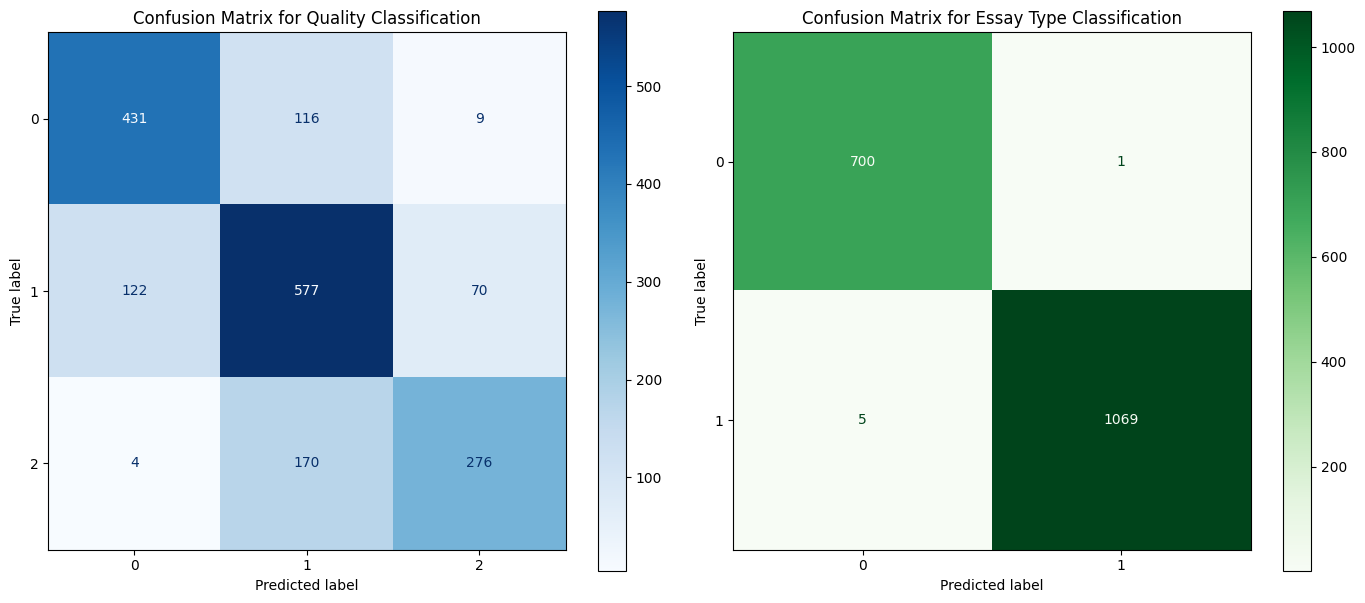

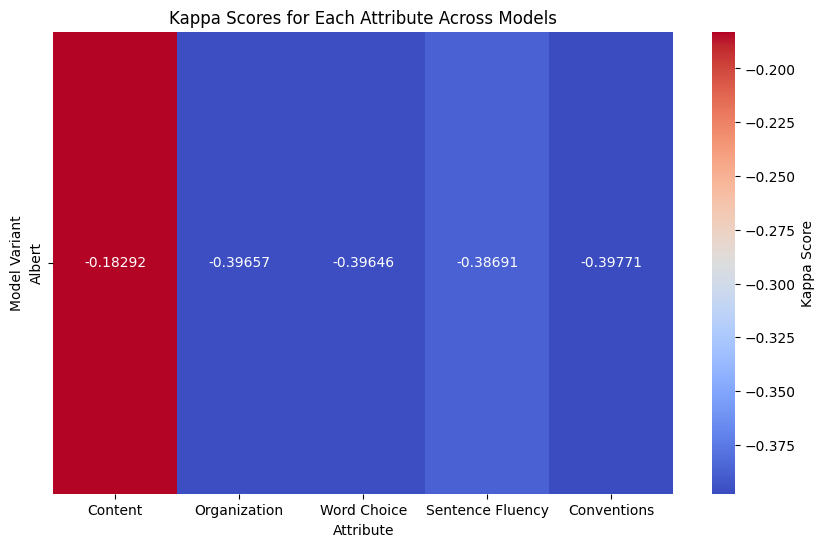

Evaluation Results: 
MSE for Score: 231.82994079589844
Quality Classification Accuracy: 0.72338
Quality Classification F1 Score: 0.72279
Quality Classification Quadratic Kappa: 0.72015
Essay Type Classification Accuracy: 0.99662
Essay Type Classification F1 Score: 0.99662
Essay Type Classification Quadratic Kappa: 0.99293
Kappa for Content: -0.18292
Kappa for Organization: -0.39657
Kappa for Word Choice: -0.39646
Kappa for Sentence Fluency: -0.38691
Kappa for Conventions: -0.39771

Training model for embedding type: glove


/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Total Epoch Loss: 591.1452
Epoch 2/10, Total Epoch Loss: 164.7580
Epoch 3/10, Total Epoch Loss: 141.3210
Epoch 4/10, Total Epoch Loss: 126.4779
Epoch 5/10, Total Epoch Loss: 117.9521
Epoch 6/10, Total Epoch Loss: 111.5759
Epoch 7/10, Total Epoch Loss: 106.8994
Epoch 8/10, Total Epoch Loss: 104.1626
Epoch 9/10, Total Epoch Loss: 102.4627
Epoch 10/10, Total Epoch Loss: 100.1940


/tmp/slurm-salsabila.pranida-50737/ipykernel_1263046/601062493.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


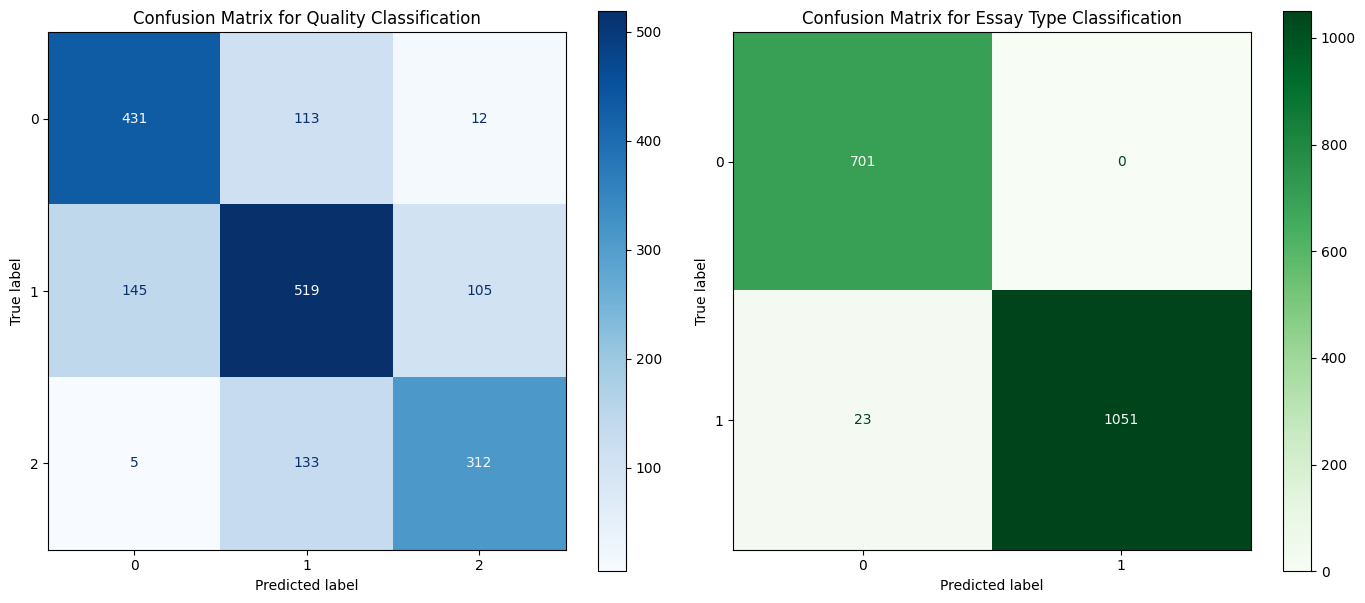

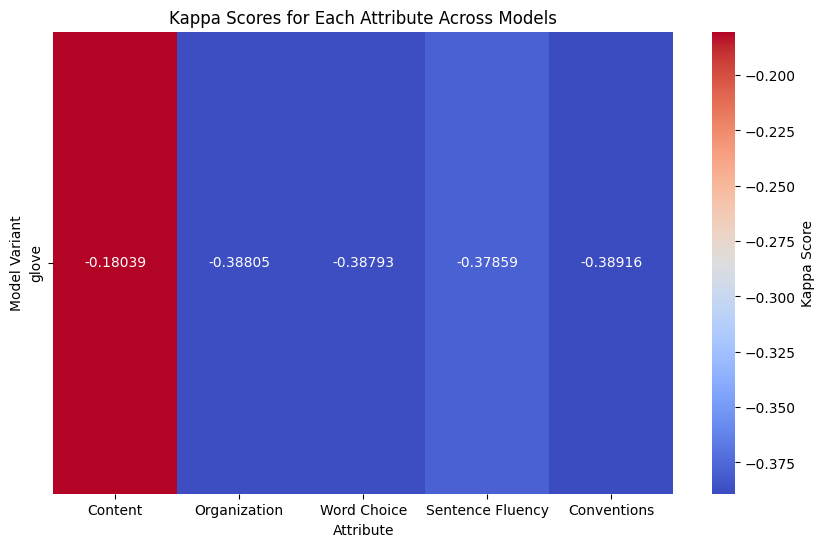

Evaluation Results: 
MSE for Score: 228.6695098876953
Quality Classification Accuracy: 0.71099
Quality Classification F1 Score: 0.71061
Quality Classification Quadratic Kappa: 0.71770
Essay Type Classification Accuracy: 0.98704
Essay Type Classification F1 Score: 0.98708
Essay Type Classification Quadratic Kappa: 0.97304
Kappa for Content: -0.18039
Kappa for Organization: -0.38805
Kappa for Word Choice: -0.38793
Kappa for Sentence Fluency: -0.37859
Kappa for Conventions: -0.38916

Training model for embedding type: fasttext


/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/salsabila.pranida/.conda/envs/ai_aes/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Total Epoch Loss: 596.2493
Epoch 2/10, Total Epoch Loss: 161.6910
Epoch 3/10, Total Epoch Loss: 141.6329
Epoch 4/10, Total Epoch Loss: 129.9670
Epoch 5/10, Total Epoch Loss: 115.4428
Epoch 6/10, Total Epoch Loss: 110.0464
Epoch 7/10, Total Epoch Loss: 105.3834
Epoch 8/10, Total Epoch Loss: 104.2354
Epoch 9/10, Total Epoch Loss: 102.6162
Epoch 10/10, Total Epoch Loss: 101.6456


/tmp/slurm-salsabila.pranida-50737/ipykernel_1263046/601062493.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


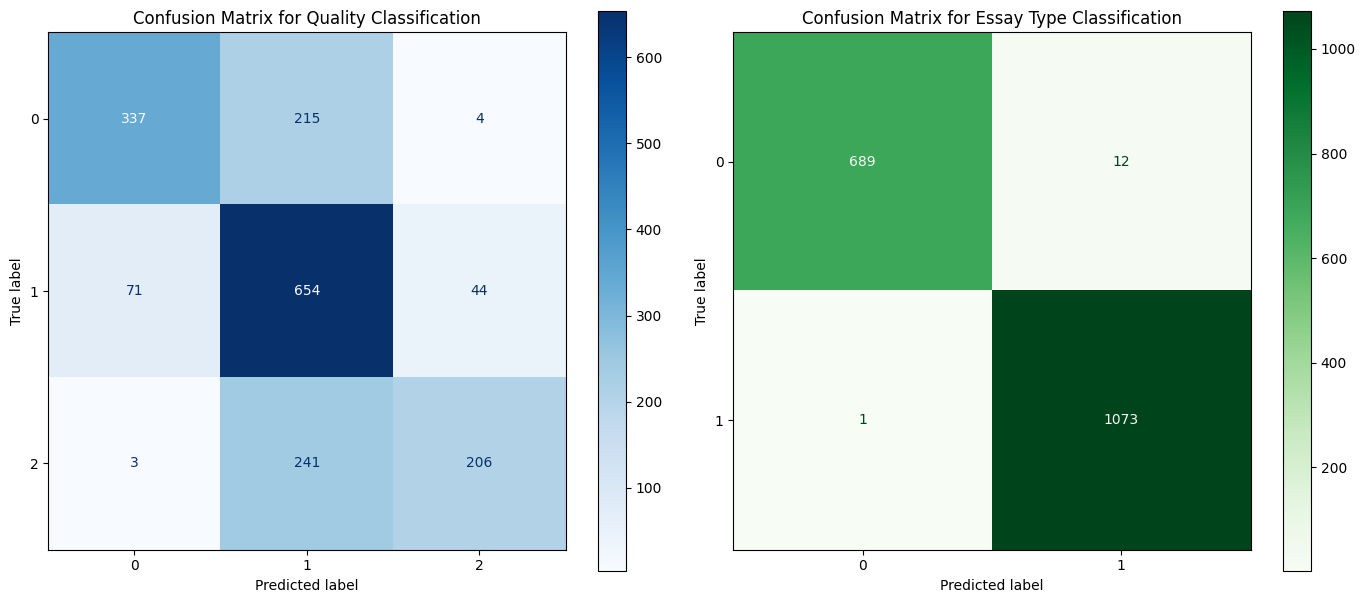

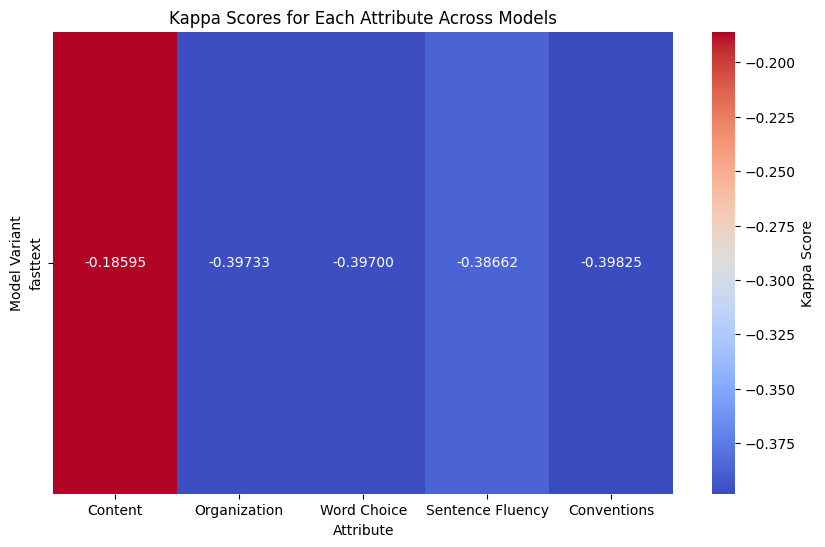

Evaluation Results: 
MSE for Score: 224.5214385986328
Quality Classification Accuracy: 0.67437
Quality Classification F1 Score: 0.66828
Quality Classification Quadratic Kappa: 0.63746
Essay Type Classification Accuracy: 0.99268
Essay Type Classification F1 Score: 0.99267
Essay Type Classification Quadratic Kappa: 0.98463
Kappa for Content: -0.18595
Kappa for Organization: -0.39733
Kappa for Word Choice: -0.39700
Kappa for Sentence Fluency: -0.38662
Kappa for Conventions: -0.39825


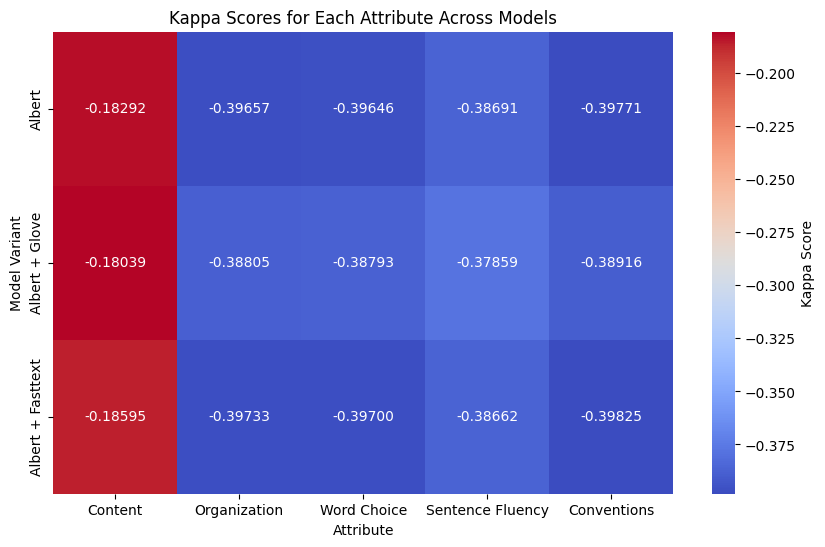

In [14]:
# Define embedding types to experiment with: ALBERT-only, ALBERT + GloVe, and ALBERT + FastText
embedding_types = [None, "glove", "fasttext"]
all_kappa_scores = []  # List to store Kappa scores for all attribute evaluations across models

for embedding_type in embedding_types:
    # Set the model name based on embedding type for easier tracking
    model_name = embedding_type if embedding_type else 'Albert'

    # Generate embeddings for each essay text, optionally combining ALBERT with GloVe or FastText embeddings
    embeddings_and_sizes = df['essay'].apply(lambda x: create_combined_embedding(x, embedding_type, glove_model, fasttext_model))

    # Unpack the combined embedding data (embedding vector and its size) for each essay
    df['embeddings'], embedding_sizes = zip(*embeddings_and_sizes)

    # Convert embedding sizes to numpy array to track embedding dimensions later if needed
    embedding_sizes = np.array(embedding_sizes)

    # Split the data into training and testing sets for model evaluation
    X_train, X_test, y_train, y_test, y_train_quality, y_test_quality, y_train_essay_type, y_test_essay_type, \
    y_train_content, y_test_content, y_train_organization, y_test_organization, y_train_word_choice, y_test_word_choice, \
    y_train_sentence_fluency, y_test_sentence_fluency, y_train_conventions, y_test_conventions = train_test_split(
        np.stack(df['embeddings'].values), 
        df['normalized_score'].values, 
        df['quality_label'].values,
        df['essay_type'].values,
        df['content'].values,
        df['organization'].values,
        df['word_choice'].values,
        df['sentence_fluency'].values,
        df['conventions'].values,
        test_size=0.2, random_state=42
    )

    # Convert each subset to PyTorch tensors for compatibility with the training process
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Reshape for regression target
    y_train_quality_tensor = torch.tensor(y_train_quality, dtype=torch.long)
    y_train_essay_type_tensor = torch.tensor(y_train_essay_type, dtype=torch.long)
    y_train_content_tensor = torch.tensor(y_train_content, dtype=torch.float32)
    y_train_organization_tensor = torch.tensor(y_train_organization, dtype=torch.float32)
    y_train_word_choice_tensor = torch.tensor(y_train_word_choice, dtype=torch.float32)
    y_train_sentence_fluency_tensor = torch.tensor(y_train_sentence_fluency, dtype=torch.float32)
    y_train_conventions_tensor = torch.tensor(y_train_conventions, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
    y_test_quality_tensor = torch.tensor(y_test_quality, dtype=torch.long)
    y_test_essay_type_tensor = torch.tensor(y_test_essay_type, dtype=torch.long)
    y_test_content_tensor = torch.tensor(y_test_content, dtype=torch.float32)
    y_test_organization_tensor = torch.tensor(y_test_organization, dtype=torch.float32)
    y_test_word_choice_tensor = torch.tensor(y_test_word_choice, dtype=torch.float32)
    y_test_sentence_fluency_tensor = torch.tensor(y_test_sentence_fluency, dtype=torch.float32)
    y_test_conventions_tensor = torch.tensor(y_test_conventions, dtype=torch.float32)
 
    # Train the model with the current embedding type and save it for future evaluation
    print(f"\nTraining model for embedding type: {embedding_type or 'albert'}")
    model_path = train_and_save_model_x(
        X_train_tensor, y_train_tensor, y_train_quality_tensor, y_train_essay_type_tensor, 
        y_train_content_tensor, y_train_organization_tensor, y_train_word_choice_tensor, 
        y_train_sentence_fluency_tensor, y_train_conventions_tensor, 
        X_train_tensor.shape[1], SAVE_DIR, epochs=10, batch_size=8, learning_rate=1e-3
    )

    # Evaluate the trained model and collect metrics, particularly Kappa scores for each attribute
    mse, accuracy_quality, f1_quality, kappa_quality, accuracy_essay_type, f1_essay_type, kappa_essay_type, \
    kappa_content, kappa_organization, kappa_word_choice, kappa_sentence_fluency, kappa_conventions = evaluate_model_x(
        model_path, X_test_tensor, y_test_tensor.squeeze().numpy(), 
        y_test_quality_tensor, y_test_essay_type_tensor,
        y_test_content_tensor, y_test_organization_tensor, y_test_word_choice_tensor, 
        y_test_sentence_fluency_tensor, y_test_conventions_tensor, SAVE_DIR, model_name
    )
    
    # Append Kappa scores for each attribute to all_kappa_scores to plot later
    all_kappa_scores.append([kappa_content, kappa_organization, kappa_word_choice, kappa_sentence_fluency, kappa_conventions])

# Plot a heatmap of Kappa scores for each model variant to visualize attribute-level performance
plot_kappa_heatmap(all_kappa_scores, model_names=['Albert', 'Albert + Glove', 'Albert + Fasttext'], attribute_names=['Content', 'Organization', 'Word Choice', 'Sentence Fluency', 'Conventions'])

In [7]:
content = """
    In “Let there be dark,” Paul Bogard talks about the importance of darkness.
Darkness is essential to humans. Bogard states, “Our bodies need darkness to produce the hormone melatonin, which keeps certain cancers from developing, and our bodies need darkness for sleep, sleep. Sleep disorders have been linked to diabetes, obesity, cardiovascular disease and depression and recent research suggests are main cause of “short sleep” is “long light.” Whether we work at night or simply take our tablets, notebooks and smartphones to bed, there isn’t a place for this much artificial light in our lives.” (Bogard 2). Here, Bogard talks about the importance of darkness to humans. Humans need darkness to sleep in order to be healthy.
Animals also need darkness. Bogard states, “The rest of the world depends on darkness as well, including nocturnal and crepuscular species of birds, insects, mammals, fish and reptiles. Some examples are well known—the 400 species of birds that migrate at night in North America, the sea turtles that come ashore to lay their eggs—and some are not, such as the bats that save American farmers billions in pest control and the moths that pollinate 80% of the world’s flora. Ecological light pollution is like the bulldozer of the night, wrecking habitat and disrupting ecosystems several billion years in the making. Simply put, without darkness, Earth’s ecology would collapse...” (Bogard 2). Here Bogard explains that animals, too, need darkness to survive.
""" 

In [11]:
results = {}
embedding_types = [None, "glove", "fasttext"]

for embedding_type in embedding_types:
    if embedding_type is None:
        embedding_type_name = "ALBERT"
    elif embedding_type == "glove":
        embedding_type_name = "ALBERT + GloVe"
    elif embedding_type == "fasttext":
        embedding_type_name = "ALBERT + FastText"

    score, quality_label, essay_type, content, organization, word_choice, sentence_fluency, conventions = testContent(
            content, 
            embedding_type=embedding_type, 
            SAVE_DIR=SAVE_DIR, 
            glove_model=glove_model, 
            fasttext_model=fasttext_model,
            attribute_ranges=attribute_ranges  # Pass attribute_ranges here
        )

    results[embedding_type_name] = {
        "score": score, 
        "quality": quality_label, 
        "essay_type": essay_type,
        "content": content, 
        "organization": organization, 
        "word_choice": word_choice, 
        "sentence_fluency": sentence_fluency,
        "conventions": conventions, 
    }

# Display the results
for embedding_name, result in results.items():
    print(f"Sample Essay Scores for {embedding_name}:")
    print(f"  Score: {result['score']} - Quality: {result['quality']} - Essay Type: {result['essay_type']}")
    print(f"  Content: {result['content']} - Organization: {result['organization']} - Word Choice: {result['word_choice']}")
    print(f"  Sentence Fluency: {result['sentence_fluency']} - Conventions: {result['conventions']}")

Sample Essay Scores for ALBERT:
  Score: 80.72536 - Quality: High - Essay Type: Dependent
  Content: 3 - Organization: 2 - Word Choice: 2
  Sentence Fluency: 2 - Conventions: 2
Sample Essay Scores for ALBERT + GloVe:
  Score: 47.50058 - Quality: Low - Essay Type: Argumentative
  Content: 2 - Organization: 2 - Word Choice: 2
  Sentence Fluency: 2 - Conventions: 2
Sample Essay Scores for ALBERT + FastText:
  Score: 45.24131 - Quality: Low - Essay Type: Dependent
  Content: 3 - Organization: 2 - Word Choice: 2
  Sentence Fluency: 2 - Conventions: 2
